In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
import pickle
#pd.set_option('display.max_colwidth', None)
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q

In [25]:
complaints_orig = pd.read_csv('../data/complaints.csv')
complaints = complaints_orig
complaints

,Consumer complaint narrative,Issue
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam
2,I have a particular account that is stating th...,Incorrect information on your report
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report
...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage


# Cleanup

In [26]:
#rename the column
complaints = complaints.rename(columns={"Consumer complaint narrative": "complaint"})

In [27]:
complaints.Issue.unique()

array(['Incorrect information on your report', 'Fraud or scam',
       'Attempts to collect debt not owed', 'Communication tactics',
       'Struggling to pay mortgage'], dtype=object)

In [28]:
complaints_ORIG =complaints

In [29]:
complaints_cleaned =complaints

In [30]:
complaints_cleaned

,complaint,Issue
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam
2,I have a particular account that is stating th...,Incorrect information on your report
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report
...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage


# Cleanup - clean_text

In [31]:
import string
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
REPLACE_XX = re.compile('XX(X+|[/.])')
REPLACE_NUMBERS = re.compile('[0-9]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_XX.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = REPLACE_NUMBERS.sub('', text) # delete numbers which are in REPLACE_NUMBERS from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    


In [32]:
#Call the clean_text function
complaints['comp_cleaned'] = complaints['complaint'].apply(clean_text)

In [33]:
complaints.Issue.value_counts()

Issue
Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: count, dtype: int64

In [34]:
# PerctOfRows = 0.8
# # #@sampled_df = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_1 = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_2 = complaints[complaints['Issue'] == 'Attempts to collect debt not owed'].sample(frac=PerctOfRows)
# complaints_3 = complaints[complaints['Issue'] == 'Communication tactics'].sample(frac=PerctOfRows)
# complaints_4 = complaints[complaints['Issue'] == 'Struggling to pay mortgage'].sample(frac=PerctOfRows)
# complaints_5 = complaints[complaints['Issue'] == 'Fraud or scam'].sample(frac=PerctOfRows)

In [35]:
#complaints_5

In [36]:
# frames = [complaints_1, complaints_2, complaints_3, complaints_4, complaints_5  ]
# complaints = pd.concat(frames)
# complaints

In [37]:
# complaints = complaints.reset_index(drop=True)

In [38]:
complaints.Issue.value_counts()

Issue
Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: count, dtype: int64

In [39]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_df = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Issue']].values)
complaints

,complaint,Issue,comp_cleaned,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,name complaint made error neither made third p...,0
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,searched pointed website legitimately believed...,1
2,I have a particular account that is stating th...,Incorrect information on your report,particular account stating owe listed credit r...,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,supplied proof doctrine estoppel silence engel...,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,hello im writing regarding account credit repo...,0
...,...,...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed,collections account knowledge,2
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed,dear cfpb team reason complaint tried resolve ...,2
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed,frca violations failing follow debt dispute pr...,2
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage,father acquired hecm reverse mortgage property...,4


In [37]:
# from sklearn.utils import shuffle
# complaints = shuffle(complaints)
# complaints


In [38]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(complaints.comp_cleaned).toarray()
# labels = complaints.category_id
# features.shape

In [39]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 10
# for Issue, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names_out())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   #Trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
#   print("# '{}':".format(Issue))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
#   #print("  . Most correlated Trigrams:\n. {}".format('\n. '.join(Trigrams[-N:])))

In [9]:
def getWordsInDFByList(dfSource, search_words, category):
    
    df = dfSource[dfSource['Issue'] == category]
    # use str.count to count the occurrences of each search word
    counts = pd.Series({word: df['comp_cleaned'].str.count(word).sum() for word in search_words})
    
   
    
    counts = pd.DataFrame(counts).reset_index()
    #rename columns
    cols = ['word','count']
    counts.columns = cols

    counts = counts.sort_values(by=['count'] ,ascending=False)
    # print the counts
    #print(counts)
    return counts

# Function pretty_conf_matrix

In [10]:
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# df_labels_unique = dataframe unique label values
#cmap_color_pl - sns color pallete e.g. "Blues", "Reds"
# title - string Title
def pretty_conf_matrix(cf_matrix, df_labels_unique, cmap_color_pl, title) : 
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)


    ax = sns.heatmap(cf_matrix, annot=True, square= True, cmap='Blues', cbar=False, fmt='d', xticklabels=df_labels_unique,
                     yticklabels=df_labels_unique )
    

    # set x-axis label and ticks. 
    #ax.set_xlabel("Predicted ", fontsize=14, labelpad=20)
    #ax.xaxis.set_ticklabels(['Negative', 'Positive'])

    # set y-axis label and ticks
    #ax.set_ylabel("Actual ", fontsize=14, labelpad=20)
    #ax.yaxis.set_ticklabels(['Negative', 'Positive'])

    ax.set_yticklabels(ax.get_yticklabels(), va='center')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # set plot title
    ax.set_title(title, fontsize=14, pad=20)

    plt.show()

In [42]:
#Convert Issue to numeric columns
# c1 = complaints.head(1000)
# c1['Issue_id'] = c1['Issue'].factorize()[0]

In [43]:
# # extract distinct patterns with 'XX'
# c1 = complaints.head(1000)
# XX_ = pd.Series(c1['complaint'].str.findall(r'XX(X+|[/.])').sum()).unique()

# # print the distinct patterns
# print(XX_)

## Top words in each issue Category

In [51]:
def GetTopWordsbyIssue(df, itemIssue):
    import nltk
    import pandas as pd
    from nltk.corpus import stopwords
    from collections import Counter

    # Load the dataframe
    df = df[df['Issue'] == itemIssue]

    # Define the stop words to exclude
    stop_words = set(stopwords.words('english'))

    # Tokenize the category column and exclude stopwords
    category_words = [word.lower() for word in nltk.word_tokenize(df['comp_cleaned'].str.cat(sep=' ')) if word.lower() not in stop_words]
    category_words
    # Retrieve the top 100 most common words
    top_words = Counter(category_words).most_common(100)
    top_words=pd.DataFrame(top_words, columns=['word','count']).sort_values(by=['count'] ,ascending=False)
    print( itemIssue + " - Top words")
    print(top_words)
    return top_words

In [52]:
# IncorrectInfoWords = GetTopWordsbyIssue(complaints,'Incorrect information on your report')
# IncorrectInfoWords.to_csv('../WCount/IncorrectInfoWords.csv', index=False)  

In [53]:
# AttemptsToCollect =GetTopWordsbyIssue(complaints,'Attempts to collect debt not owed')
# AttemptsToCollect.to_csv('../WCount/AttemptsToCollect.csv', index=False)  

In [54]:
#C3 = GetTopWordsbyIssue(complaints,'Communication tactics')

In [55]:
#C4 = GetTopWordsbyIssue(complaints,'Struggling to pay mortgage')

In [56]:
#C5 = GetTopWordsbyIssue(complaints,'Fraud or scam')

# Rods Code to find common words and cleanup

In [58]:
incorrect_info=complaints[complaints['Issue']=='Incorrect information on your report']
collect_debt=complaints[complaints['Issue']=='Attempts to collect debt not owed']
communication=complaints[complaints['Issue']=='Communication tactics']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# select the issues with shared words and combine into a single corpus
corpus = incorrect_info['comp_cleaned'].tolist() + collect_debt['comp_cleaned'].tolist()

vectorizer = CountVectorizer(stop_words='english')

word_frequency_dict = {}

# process the corpus in chunks to calculate word frequencies incrementally
chunk_size = 1000
num_samples = len(corpus)

for i in range(0, num_samples, chunk_size):
    chunk = corpus[i:i+chunk_size]
    X = vectorizer.fit_transform(chunk)
    feature_names = vectorizer.get_feature_names_out()
    word_frequencies = X.toarray().sum(axis=0)
    
    # update the word frequency dictionary
    for word, frequency in zip(feature_names, word_frequencies):
        word_frequency_dict[word] = word_frequency_dict.get(word, 0) + frequency

# sort the dictionary by frequency in descending order
sorted_words = sorted(word_frequency_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:20]
for word, frequency in top_words:
    print(f"{word}: {frequency}")

# Models

## C-1. Split Data - holding data

In [ ]:
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# X = complaints['comp_cleaned']
# y = complaints['Issue']

# #Get holding data from X_train, y_train
# X_train, X_test_hold, y_train, y_test_hold = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# C-2 Split -  X_train, X_test, y_train, y_test 

In [ ]:
# #Split again to get X_train, X_test and get holding data from X_train, y_train
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

## C-3 - Replace words

In [ ]:
# # Function to remove words from a string
# def remove_words(text, words):
#     return ' '.join([word for word in text.split() if word not in words])

In [ ]:
#Create DF from X_train, y_train



# df_X_train_y_train  = pd.concat([X_train, y_train], axis=1)

In [ ]:
# # list of words to remove from 'Incorrect information on your report'
# words_to_remove_Incorr_Info = ['also', 'back', 'inaccurate', 'information', 'cards', 'know', 'made',
#                    'mine', 'name', 'one', 'opened', 'original', 'person', 'please','debt',
# 'identity', 'theft', 'collection', 'need', 'made', 'law', 'late','never'
#                    'said', 'told', 'usc', 'within', 'would','years']



# # Filter the words for 'Incorrect information on your report'
# df_X_train_y_train.loc[df_X_train_y_train['Issue'] == 'Incorrect information on your report', 'comp_cleaned'] = df_X_train_y_train.loc[df_X_train_y_train['Issue'] == 'Incorrect information on your report', 'comp_cleaned'].apply(lambda x: remove_words(x, words_to_remove_Incorr_Info))


# #df_X_train_y_train.to_csv('../temp/df_X_train_y_train_After_1.csv')  
# # Output the result
# df_X_train_y_train


## C-4 Separate dataframe df_X_train_y_train back to X_train & y_train

In [ ]:

# # list of words to remove from 'Attempts to collect debt not owed'
# words_to_remove_attm_coll_debt = ['collection', 'credit', 'creditor', 'debt', 'dispute',
#                     'disputed', 'even', 'identity', 'fraud', 'fraudulent', '#', 'bureaus',
#                     'act']

# # Filter the words for 'Attempts to collect debt not owed'
# df_X_train_y_train.loc[df_X_train_y_train['Issue'] == 'Attempts to collect debt not owed', 'comp_cleaned'] = df_X_train_y_train.loc[df_X_train_y_train['Issue'] == 'Attempts to collect debt not owed', 'comp_cleaned'].apply(lambda x: remove_words(x, words_to_remove_attm_coll_debt))


# #df_X_train_y_train.to_csv('../temp/X_train_After_2.csv', index=False)  
# # Output the result
# print(df_X_train_y_train)




In [ ]:
# #X_train = df_X_train_y_train[['comp_cleaned']].to_numpy()
# X_train = df_X_train_y_train.loc[:,'comp_cleaned']

# #y_train = df_X_train_y_train[['Issue']].to_numpy()
# y_train = df_X_train_y_train.loc[:,'Issue']

# GridSearchCV - LinearSVC

In [59]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])



param_grid = {'kernel': ('linear', 'rbf'),
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
    }
    

grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

Fitting 3 folds for each of 72 candidates, totalling 216 fits
                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.83      0.78      0.80     18412
               Communication tactics       0.85      0.79      0.82      5257
                       Fraud or scam       0.93      0.90      0.91      3122
Incorrect information on your report       0.94      0.96      0.95     57230
          Struggling to pay mortgage       0.94      0.95      0.94      4337

                            accuracy                           0.91     88358
                           macro avg       0.89      0.88      0.88     88358
                        weighted avg       0.91      0.91      0.91     88358

Best: 0.904076 using {'clf__C': 1.0, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
0.866034 (0.000545) with: {'clf__C': 0.1, 'tfidf__max_df': 0.125, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
0.88465

array([[14276,   625,   109,  3317,    85],
       [  874,  4162,    23,   173,    25],
       [   91,    23,  2801,   194,    13],
       [ 1978,    57,    77, 54955,   163],
       [   45,    37,     8,   117,  4130]], dtype=int64)

# 2. Model with HalvingGridSearchCV - This randomly picks parameters insetad of running the model for all parameters, reducing the run time

In [17]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.experimental import enable_halving_search_cv # noqa

X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])



param_grid = {
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
    }
    

grid = HalvingGridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9817
max_resources_: 265074
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 9817
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 29451
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 88353
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 265059
Fitting 3 folds for each of 3 candidates, totalling 9 fits
                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.83      0.78      0.80     18412
               Communication tactics       0.85      0.79      0.82      5257
                       Fraud or scam       0.93      0.90      0.91      3122
Incorrect information on your report       0.94      0.96      0.95     57230

array([[14276,   625,   109,  3317,    85],
       [  874,  4162,    23,   173,    25],
       [   91,    23,  2801,   194,    13],
       [ 1978,    57,    77, 54955,   163],
       [   45,    37,     8,   117,  4130]], dtype=int64)

# HalvingGridSearchCV - LinearSVC

In [49]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.experimental import enable_halving_search_cv # noqa

X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])




param_grid = {
    'clf__max_iter':[1500],
    'clf__multi_class' :['ovr'],
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 2), (1, 3)]
    }
    

grid = HalvingGridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

    #1 save the model to disk
filename = 'A_Grid_LinearSVC_ParamChanges.pickle'
pickle.dump(grid, open(filename, 'wb'))

from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9817
max_resources_: 265074
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 9817
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 16
n_resources: 29451
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 6
n_resources: 88353
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 265059
Fitting 3 folds for each of 2 candidates, totalling 6 fits
                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.83      0.78      0.80     18412
               Communication tactics       0.85      0.79      0.82      5257
                       Fraud or scam       0.93      0.90      0.91      3122
Incorrect information on your report       0.94      0.96      0.95     57230

array([[14276,   625,   109,  3317,    85],
       [  874,  4162,    23,   173,    25],
       [   91,    23,  2801,   194,    13],
       [ 1978,    57,    77, 54955,   163],
       [   45,    37,     8,   117,  4130]], dtype=int64)

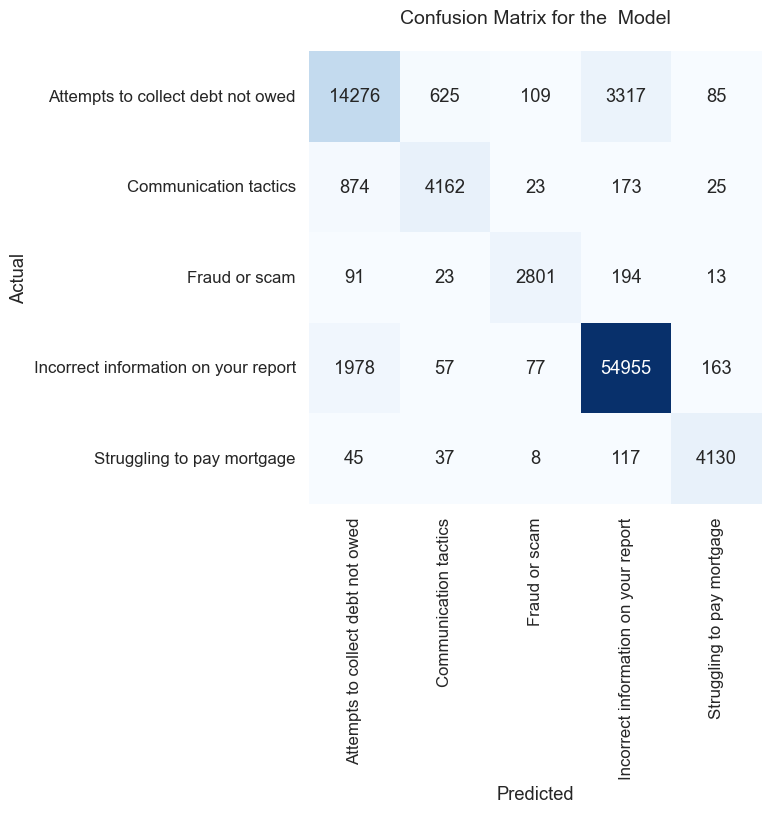

In [50]:
pretty_conf_matrix(cm, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

# HalvingGridSearchCV - LinearSVC

ngram_range': [(1, 2), (1, 3), (1, 4)]

In [51]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.experimental import enable_halving_search_cv # noqa

X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])




param_grid = {
    'clf__max_iter':[1500],
    'clf__multi_class' :['ovr'],
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)]
    }
    

grid = HalvingGridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

    #1 save the model to disk
filename = 'A_Grid_LinearSVC_ParamChanges_ngram_1_4.pickle'
pickle.dump(grid, open(filename, 'wb'))

from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9817
max_resources_: 265074
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 9817
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 29451
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 88353
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 265059
Fitting 3 folds for each of 3 candidates, totalling 9 fits
                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.83      0.78      0.80     18412
               Communication tactics       0.84      0.79      0.82      5257
                       Fraud or scam       0.92      0.90      0.91      3122
Incorrect information on your report       0.94      0.96      0.95     57230

array([[14384,   639,   126,  3168,    95],
       [  886,  4160,    25,   160,    26],
       [   90,    24,  2821,   172,    15],
       [ 1980,    69,    84, 54914,   183],
       [   43,    39,    12,    99,  4144]], dtype=int64)

# HalvingGridSearchCV - LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.experimental import enable_halving_search_cv # noqa

X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(multi_class='multinomial',solver='newton-cg')),
])



param_grid = {
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
    }
    

grid = HalvingGridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9817
max_resources_: 265074
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 9817
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 29451
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 88353
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 265059
Fitting 3 folds for each of 3 candidates, totalling 9 fits
                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.81      0.74      0.77     18412
               Communication tactics       0.85      0.76      0.80      5257
                       Fraud or scam       0.93      0.86      0.89      3122
Incorrect information on your report       0.92      0.96      0.94     57230

array([[13680,   595,    99,  3934,   104],
       [  982,  4018,    21,   205,    31],
       [  124,    32,  2691,   258,    17],
       [ 2150,    56,    74, 54739,   211],
       [   52,    46,    13,   163,  4063]], dtype=int64)

# HalvingGridSearchCV with XGBClassifier

In [40]:
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv
from xgboost import XGBClassifier

X = complaints['comp_cleaned']
y = complaints['category_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier()),
])



param_grid = {
         'clf__C':[0.1,1.0],
        'tfidf__min_df': (1, 0.001, 0.01),
        'tfidf__max_df': (0.125, 0.25, 0.5, 0.75),
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
    }
    

grid = HalvingGridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=8,  verbose=3)
grid.fit(X_train,y_train)


# best estimator to fit
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
 

# summarize results
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9817
max_resources_: 265074
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 9817
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 29451
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 88353
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 265059
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[12:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "C" } are not used.

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     57230
           1       0.93      0.86      0.89      3122
           2       0.77      0.71   

array([[54244,    74,  2692,    78,   142],
       [  291,  2675,   101,    43,    12],
       [ 4357,   104, 13145,   704,   102],
       [  247,    21,  1000,  3959,    30],
       [  244,    11,    53,    50,  3979]], dtype=int64)

In [41]:
#1 save the model to disk
filename = 'A_Grid_XGBClassifier.pickle'
pickle.dump(grid, open(filename, 'wb'))


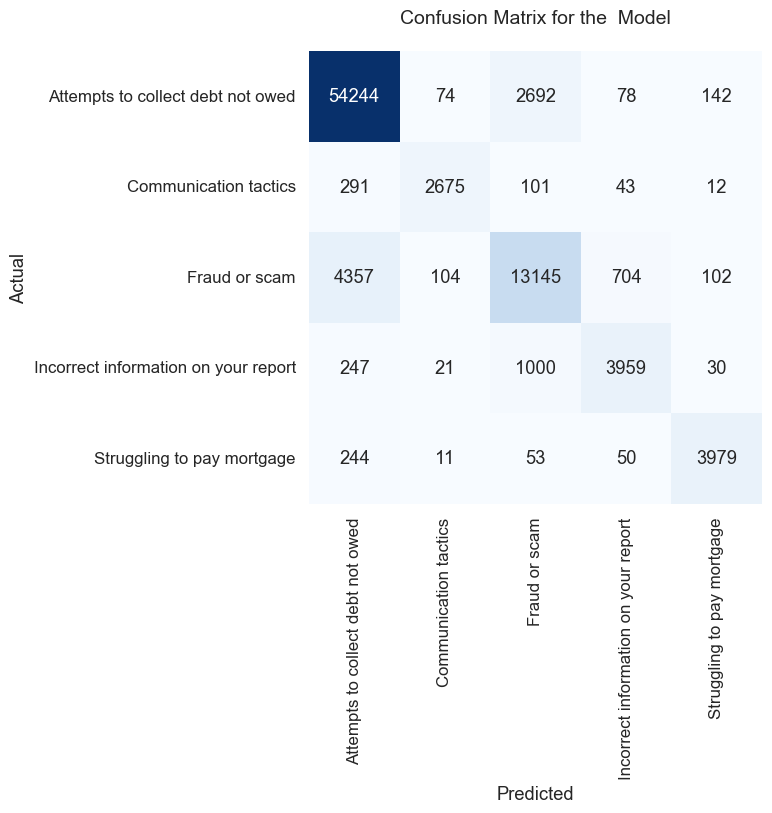

In [42]:
pretty_conf_matrix(cm, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")